### Loading the dataset

In [3]:
classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

# inside these folders there are multiple text files

import glob
import os

texts = [] # texts from all the text files
class_labels = [] # labels

for c in classes:
    for f in glob.glob(os.path.join('bbc', c, '*.txt')):
        texts.append(open(f).read())
        class_labels.append(c)

In [4]:
print(len(texts))
print(len(class_labels))
print(texts[0])
print(class_labels[0])

2225
2225
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to 

> We have 5 classes ['business', 'entertainment', 'politics', 'sport', 'tech']

### Random Seed and Data Shuffling

In [5]:
import random
import numpy
import torch

random.seed(10)
numpy.random.seed(10)
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

z = list(zip(texts, class_labels))
random.shuffle(z)

texts, class_labels = [a[0] for a in z], [a[1] for a in z]

In [6]:
class_labels[-20:]

['sport',
 'entertainment',
 'sport',
 'business',
 'sport',
 'politics',
 'business',
 'sport',
 'tech',
 'tech',
 'business',
 'entertainment',
 'politics',
 'tech',
 'tech',
 'entertainment',
 'business',
 'tech',
 'sport',
 'business']

In [7]:
from collections import Counter
Counter(class_labels)

Counter({'politics': 417,
         'business': 510,
         'entertainment': 386,
         'tech': 401,
         'sport': 511})

### Tokenizer

In [8]:
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length = 512, padding_side = 'right')

input_ids = torch.tensor(tokenizer.encode(texts[0], add_special_tokens=True, max_length = 512, pad_to_max_length = True)).unsqueeze(0)  # Batch size 1

In [9]:
print(input_ids)

tensor([[  101,  2829,  7879, 22889,  2819,  2006,  3088,  4440,  7306,  5146,
          2829,  2038,  4716,  7938,  1005,  1055,  5221, 17137,  3723,  4665,
          2004,  2002,  2441,  1037,  2733,  1011,  2146,  3942,  2000,  3088,
          1012,  2720,  2829,  1005,  1055,  4440,  2003,  2881,  2000, 12944,
          2129,  1996,  2866,  4122,  2000,  2191,  3088,  1005,  1055,  3471,
          1037,  9470,  1997,  2049,  3472,  9650,  1997,  1996,  1043,  2620,
          2023,  2095,  1012,  2002,  2097,  2156,  2019,  9820,  1013,  8387,
         18504,  1999, 11959,  1998,  1037,  2308,  1005,  1055,  4923,  2586,
          1999, 16274,  2077,  3242,  2075,  1037,  3116,  1997,  1996,  3222,
          2005,  3088,  1999,  4880,  2237,  1012,  2012, 22889, 18163,  1999,
          6583,  3217,  5638,  2006,  9317,  1010,  2002,  2056,  2495,  3791,
          2018,  2000,  2022, 26176,  1012,  4092,  2648,  1996,  4386,  3078,
          2082,  1010,  2720,  2829,  2056,  1024,  

In [10]:
len(input_ids[0])

512

In [11]:
# we also need attention masks

encoded = tokenizer.encode_plus(texts[0], add_special_tokens=True, max_length = 512, pad_to_max_length = True,
                                return_token_type_ids = False,
                                return_attention_mask = True)  # Batch size 1

In [12]:
encoded.keys()

dict_keys(['input_ids', 'attention_mask'])

### Pre-trained BERT for sequence classification

In [25]:
from transformers import BertForSequenceClassification

bertclassifier, li = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5,
                                                                   output_loading_info=True) # as we have 5 classes

In [17]:
print(bertclassifier)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

The last linear layer has 5 out_features. `(classifier): Linear(in_features=768, out_features=5, bias=True)`

We can just add a softmax after that and do our regular classification.

In [26]:
print(li)

{'missing_keys': ['classifier.weight', 'classifier.bias'], 'unexpected_keys': ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias'], 'error_msgs': []}


In [27]:
for i, name_param in enumerate(bertclassifier.named_parameters()):
    print(i, name_param[0])
    # we freeze first 21 layers (first encoder)
    if i <= 20:
        name_param[1].requires_grad = False

0 bert.embeddings.word_embeddings.weight
1 bert.embeddings.position_embeddings.weight
2 bert.embeddings.token_type_embeddings.weight
3 bert.embeddings.LayerNorm.weight
4 bert.embeddings.LayerNorm.bias
5 bert.encoder.layer.0.attention.self.query.weight
6 bert.encoder.layer.0.attention.self.query.bias
7 bert.encoder.layer.0.attention.self.key.weight
8 bert.encoder.layer.0.attention.self.key.bias
9 bert.encoder.layer.0.attention.self.value.weight
10 bert.encoder.layer.0.attention.self.value.bias
11 bert.encoder.layer.0.attention.output.dense.weight
12 bert.encoder.layer.0.attention.output.dense.bias
13 bert.encoder.layer.0.attention.output.LayerNorm.weight
14 bert.encoder.layer.0.attention.output.LayerNorm.bias
15 bert.encoder.layer.0.intermediate.dense.weight
16 bert.encoder.layer.0.intermediate.dense.bias
17 bert.encoder.layer.0.output.dense.weight
18 bert.encoder.layer.0.output.dense.bias
19 bert.encoder.layer.0.output.LayerNorm.weight
20 bert.encoder.layer.0.output.LayerNorm.bias
21 b

In [23]:
bertclassifier.eval()
bertclassifier(input_ids)

(tensor([[ 0.1064,  0.1848,  0.0699,  0.0150, -0.2364]],
        grad_fn=<AddmmBackward>),)

In [29]:
# checking the frozen layers 
print(list(bertclassifier.parameters())[20].requires_grad)

# trainable layer
print(list(bertclassifier.parameters())[-100].requires_grad)

False
True


### Writing the DataLoader

In [30]:
from torch.utils.data import Dataset, DataLoader

# create our dataset

class BBCArticleDataset(Dataset):
    def __init__(self, texts, class_labels, class_id, tokenizer, train = True, train_split = 0.8): # pass the text and the labels, class_id : dict -> ohe
        
        self.train = train
        
        assert(len(class_labels) == len(texts))
        assert(type(class_id) == dict)
        
        if self.train:
            self.texts = texts[: int(len(texts)*train_split) ]
            self.class_labels = class_labels[: int(len(texts)*train_split) ]
        else:
            self.texts = texts[ int(len(texts)*train_split): ]
            self.class_labels = class_labels[ int(len(texts)*train_split): ]
        self.class_id = class_id
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.class_labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        encoded = tokenizer.encode_plus(self.texts[idx], add_special_tokens=True, max_length = 512, pad_to_max_length = True,
                                return_token_type_ids = False,
                                return_attention_mask = True)  # Batch size 1
            
        # text to tokens
        token = torch.tensor(encoded['input_ids']) #.unsqueeze(0)
        mask = torch.tensor(encoded['attention_mask'])
        # ohe label
        ohe = torch.tensor(class_id[ class_labels[idx] ])
        
        if self.train:
            return token, mask, ohe
        else:
            return token, mask, ohe # no mask needed

In [31]:
class_id = {'business' : 0, 'entertainment' : 1,
           'politics' : 2, 'sport' : 3,
           'tech' : 4}

bbc_dataset_train = BBCArticleDataset(texts, class_labels, class_id, tokenizer)
bbc_dataset_test = BBCArticleDataset(texts, class_labels, class_id, tokenizer, train = False)

bbc_dataloader_train = DataLoader(bbc_dataset_train, batch_size=2, shuffle=True)
bbc_dataloader_test = DataLoader(bbc_dataset_test, batch_size=2, shuffle=True)

In [32]:
print(bbc_dataset_train[0][0].shape)
print(bbc_dataset_train[0][1].shape)
print(bbc_dataset_train[0][2])

torch.Size([512])
torch.Size([512])
tensor(2)


In [33]:
# let's look at few examples

for i_batch, sample_batch in enumerate(bbc_dataloader_train):
    print(i_batch)
    X, mask_X, y = sample_batch
    print(X.shape)
    print(mask_X.shape)
    print(y.shape)
    if i_batch == 10:
        break

0
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
1
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
2
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
3
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
4
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
5
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
6
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
7
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
8
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
9
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])
10
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2])


### Let's start training!

In [34]:
import transformers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda for gpu acceleration

# optimizer

optimizer = transformers.AdamW(bertclassifier.parameters(), lr = 1e-5)


bertclassifier.to(device) # taking the model to gpu if possible

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [35]:
# training epochs

epochs = 2

# metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_losses = []

train_metrics = {'acc': [], 'f1': []}
test_metrics = {'acc': [], 'f1': []}

# progress bar

from tqdm import tqdm_notebook

for e in tqdm_notebook(range(epochs)):
    train_loss = 0.0
    train_acc = 0.0
    train_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.train()
    
    print(f'epoch: {e+1}')
    
    for i_batch, (X, X_mask, y) in tqdm_notebook(enumerate(bbc_dataloader_train)):
        X = X.to(device)
        X_mask = X_mask.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
        
        loss, y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)

        train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(bertclassifier.parameters(), 1.0)

        optimizer.step()
        
        y_pred = torch.argmax(y_pred, dim = -1)
        
        # update metrics
        train_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        train_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'weighted')
        batch_cnt += 1
    
    print(f'train loss: {train_loss/batch_cnt}')
    print(f'acc: {train_acc/batch_cnt}')
    print(f'f1: {train_f1/batch_cnt}')
    train_losses.append(train_loss/batch_cnt)
    train_metrics['acc'].append(train_acc/batch_cnt)
    train_metrics['f1'].append(train_f1/batch_cnt)
        
        
    test_loss = 0.0
    test_acc = 0.0
    test_f1 = 0.0
    batch_cnt = 0
    
    bertclassifier.eval()
    with torch.no_grad():
        for i_batch, (X, X_mask, y) in enumerate(bbc_dataloader_train):
            X = X.to(device)
            X_mask = X_mask.to(device)
            y = y.to(device)

            y_pred = bertclassifier(X, attention_mask = X_mask, labels = y)[1] # in eval model we get the softmax output so, don't need to index

            
            y_pred = torch.argmax(y_pred, dim = -1)

            # update metrics
            test_acc += accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
            test_f1 += f1_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average = 'weighted')
            batch_cnt += 1
            
    test_metrics['acc'].append(test_acc/batch_cnt)
    test_metrics['f1'].append(test_f1/batch_cnt)
    print(f'test acc: {test_acc/batch_cnt}')
    print(f'test f1: {test_f1/batch_cnt}')

c:\programdata\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch: 1


c:\programdata\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train loss: 0.34490313563454017
acc: 0.902247191011236
f1: 0.9000000000000001
test acc: 0.9898876404494382
test f1: 0.9900749063670413
epoch: 2



train loss: 0.06370931147189622
acc: 0.9870786516853932
f1: 0.9880149812734081
test acc: 0.9938202247191011
test f1: 0.9941947565543071



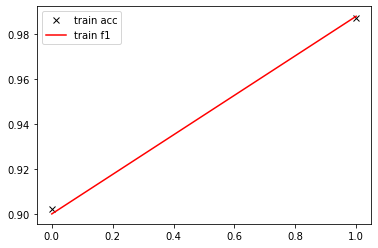

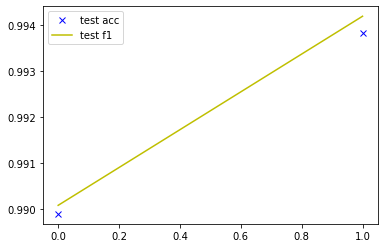

In [36]:
# plotting the result

import matplotlib.pyplot as plt

plt.plot(train_metrics['acc'], 'kx')
plt.plot(train_metrics['f1'], 'r')
plt.legend(['train acc', 'train f1'])
plt.show()
plt.plot(test_metrics['acc'], 'bx')
plt.plot(test_metrics['f1'], 'y')
plt.legend(['test acc', 'test f1'])
plt.show()